In [1]:
import altair as alt
import pandas as pd 
import numpy as np

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Proof of concept viz

## Data processing for example 1

In [2]:
example1 = pd.read_csv('../server/example1/examplematch1.robotdata.csv')

In [11]:
example1.shape, example1.columns

((148, 114),
 Index(['id', 'name', 'expires', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6',
        't_7',
        ...
        'Astrogation Buffer Length', 'Polarity Sinks',
        'Arakyd Vocabulator Model', 'Axial Piston Model', 'Nanochip Model',
        'AutoTerrain Tread Count', 'InfoCore Size', 'Sonoreceptors',
        'Cranial Uplink Bandwidth', 'Productivity'],
       dtype='object', length=114))

In [12]:
example1_robots = example1[['id','name','expires', 'Repulsorlift Motor HP','Astrogation Buffer Length', 'Polarity Sinks',
        'Arakyd Vocabulator Model', 'Axial Piston Model', 'Nanochip Model',
        'AutoTerrain Tread Count', 'InfoCore Size', 'Sonoreceptors',
        'Cranial Uplink Bandwidth', 'Productivity']]

In [13]:
example1_robots.sample()

id                  name  expires  Repulsorlift Motor HP  \
72  72  Pushminer Botberg II     56.0             -81.784504   

    Astrogation Buffer Length  Polarity Sinks Arakyd Vocabulator Model  \
72                  -0.211206        0.492593                  model D   

   Axial Piston Model Nanochip Model  AutoTerrain Tread Count  InfoCore Size  \
72              gamma           v2.0                 1.254415       1.250756   

    Sonoreceptors  Cranial Uplink Bandwidth  Productivity  
72           23.0                      64.0     97.682974

In [44]:
example1_timeseries = example1.drop(['expires','Repulsorlift Motor HP' ,'Astrogation Buffer Length', 'Polarity Sinks',
        'Arakyd Vocabulator Model', 'Axial Piston Model', 'Nanochip Model',
        'AutoTerrain Tread Count', 'InfoCore Size', 'Sonoreceptors',
        'Cranial Uplink Bandwidth', 'Productivity'], axis = 1)

In [45]:
example1_timeseries.sample()

id                 name  t_1        t_2       t_3        t_4        t_5  \
66  66  Stonewalker Botchik  0.0  10.016594  19.37179  28.088106  36.187728   

          t_6        t_7        t_8  ...       t_91       t_92       t_93  \
66  43.692513  50.623985  57.003341  ...  53.658981  55.515021  57.412944   

        t_94      t_95       t_96       t_97       t_98      t_99      t_100  
66  59.34553  61.30523  63.284164  65.274123  67.266565  69.25262  71.223086  

[1 rows x 102 columns]

In [46]:
example1_timeseries_melted = example1_timeseries.melt(id_vars = ['id','name'], var_name = 'time', value_name = 'number')

In [47]:
example1_timeseries_melted['timestamp'] = example1_timeseries_melted['time']
example1_timeseries_melted['time'] = example1_timeseries_melted['timestamp'].str.split('_',expand = True)[1].astype(int)

In [50]:
example1_timeseries_melted.sort_values(by = ['id','time'], ascending = True, inplace = True)
example1_timeseries_melted.sample(5)

id                   name  time     number timestamp
1309   125     Waterhauler Botski     9  55.156321       t_9
12379   95      Waterborer Botski    84   3.778412      t_84
11892   52      Wallhauler Botski    81  34.415927      t_81
13329    9   Wallvator Boterson I    91  46.605340      t_91
1415    83  Pulldigger Botberg II    10  36.427667      t_10

## Timeseries viz for example 1

In [52]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [283]:
timeseries_base_dot = alt.Chart(example1_timeseries_melted).mark_point(
    filled = True, 
    size = 1, 
    opacity = 0.5
).encode(
    x = alt.X('time:Q'),
    y = alt.Y('number:Q')
)

timeseries_base_regression = timeseries_base_dot.transform_regression(
    'time', 'number', method = 'poly', order = 4
).mark_line(opacity = 0.5)

# timeseries_base_r2 = timeseries_base_dot.transform_regression(
#     'time', 'number', method = 'poly', params=True, order = 5
# ).mark_text(align='left').encode(
#     x=alt.value(70),  
#     y=alt.value(20), 
#     text=alt.Text('rSquared:N', format = '.2f', title = 'r2')
# ) 

# timeseries_base_r2label = timeseries_base_r2.encode(
#     x=alt.value(10),  
#     y=alt.value(20), 
#     text=alt.value('R-squared: ')
# )

timeseries_base = alt.layer( timeseries_base_dot + timeseries_base_regression)
timeseries_base

alt.LayerChart(...)

In [313]:
robot_dropdown = alt.binding_select(options=list(example1.id.unique()))
robot_select = alt.selection_single(fields=['id'], bind=robot_dropdown, name="Robot", empty = 'none', init = {'id':0})

timeseries_robot_dot = timeseries_base_dot.mark_point(
    size = 3, 
    opacity = 1
)

timeseries_robot_regression = timeseries_robot_dot.transform_regression(
    'time', 'number', method = 'poly', order = 4
).mark_line()

timeseries_robot_r2 = timeseries_robot_dot.transform_regression(
    'time', 'number', method = 'poly', params=True, order = 4
).mark_text(align='left').encode(
    x=alt.value(160),  
    y=alt.value(20), 
    text=alt.Text('rSquared:N', format = '.2f', title = 'r2')
) 

timeseries_robot_r2label = timeseries_robot_r2.encode(
    x=alt.value(10),  
    y=alt.value(20), 
    text=alt.value('R-squared for selected robot: ')
)


timeseries_robot = alt.layer( timeseries_robot_dot + timeseries_robot_regression + timeseries_robot_r2 + timeseries_robot_r2label).add_selection(
    robot_select
).transform_filter(
    robot_select
)
timeseries = (timeseries_base + timeseries_robot).properties(height = 300)
timeseries

alt.LayerChart(...)

In [302]:
example1_count = example1_timeseries_melted[['id','number']].groupby(by = 'id').count()\
    .rename(columns = {'number':'count_hints'})\
    .reset_index().sort_values(by = 'count_hints', ascending = False)\
    .head(20)

In [305]:
# example1_count

In [314]:
robot_dropdown = alt.binding_select(options=list(example1.id.unique()))
robot_select = alt.selection_single(fields=['id'], bind=robot_dropdown, name="Robot", empty = 'none', init = {'id':0})

timeseries_robot_dot = timeseries_base_dot.mark_point(
    size = 3, 
    opacity = 1
)

timeseries_robot_regression = timeseries_robot_dot.transform_regression(
    'time', 'number', method = 'poly', order = 4
).mark_line()

timeseries_robot_r2 = timeseries_robot_dot.transform_regression(
    'time', 'number', method = 'poly', params=True, order = 4
).mark_text(align='left').encode(
    x=alt.value(160),  
    y=alt.value(20), 
    text=alt.Text('rSquared:N', format = '.2f', title = 'r2')
) 

timeseries_robot_r2label = timeseries_robot_r2.encode(
    x=alt.value(10),  
    y=alt.value(20), 
    text=alt.value('R-squared for selected robot: ')
)


timeseries_robot = alt.layer( timeseries_robot_dot + timeseries_robot_regression + timeseries_robot_r2 + timeseries_robot_r2label).add_selection(
    robot_select
).transform_filter(
    robot_select
)
timeseries = (timeseries_base + timeseries_robot).properties(height = 300)

hint_count = alt.Chart(example1_count).mark_bar().encode(
    alt.X('count_hints:Q'),
    alt.Y('id:N', sort = '-x')
).properties(width = 100, height = 300)
(timeseries | hint_count)

alt.HConcatChart(...)

In [320]:
from vega_datasets import data

source = 'https://cdn.jsdelivr.net/npm/vega-datasets@2.2.0/data/movies.json'
df = pd.read_json(source, orient = 'records')
df

Title    US Gross  Worldwide Gross  US DVD Sales  \
0                 The Land Girls    146083.0         146083.0           NaN   
1         First Love, Last Rites     10876.0          10876.0           NaN   
2     I Married a Strange Person    203134.0         203134.0           NaN   
3           Let's Talk About Sex    373615.0         373615.0           NaN   
4                           Slam   1009819.0        1087521.0           NaN   
...                          ...         ...              ...           ...   
3196  Zack and Miri Make a Porno  31452765.0       36851125.0    21240321.0   
3197                      Zodiac  33080084.0       83080084.0    20983030.0   
3198                        Zoom  11989328.0       12506188.0     6679409.0   
3199         The Legend of Zorro  45575336.0      141475336.0           NaN   
3200           The Mask of Zorro  93828745.0      233700000.0           NaN   

      Production Budget Release Date MPAA Rating  Running Time min  \
0             8000000.0  Jun 12 1998           R               NaN   
1              300000.0  Aug 07 1998           R               NaN   
2              250000.0  Aug 28 1998        None               NaN   
3              300000.0  Sep 11 1998        None               NaN   
4             1000000.0  Oct 09 1998           R               NaN   
...                 ...          ...         ...               ...   
3196         24000000.0  Oct 31 2008           R             101.0   
3197         85000000.0  Mar 02 2007           R             157.0   
3198         35000000.0  Aug 11 2006          PG               NaN   
3199         80000000.0  Oct 28 2005          PG             129.0   
3200         65000000.0  Jul 17 1998       PG-13             136.0   

             Distributor                        Source        Major Genre  \
0               Gramercy                          None               None   
1                 Strand                          None              Drama   
2              Lionsgate                          None             Comedy   
3              Fine Line                          None             Comedy   
4                Trimark           Original Screenplay              Drama   
...                  ...                           ...                ...   
3196       Weinstein Co.           Original Screenplay             Comedy   
3197  Paramount Pictures     Based on Book/Short Story  Thriller/Suspense   
3198       Sony Pictures  Based on Comic/Graphic Novel          Adventure   
3199       Sony Pictures                        Remake          Adventure   
3200       Sony Pictures                        Remake          Adventure   

             Creative Type         Director  Rotten Tomatoes Rating  \
0                     None             None                     NaN   
1                     None             None                     NaN   
2                     None             None                     NaN   
3                     None             None                    13.0   
4     Contemporary Fiction             None                    62.0   
...                    ...              ...                     ...   
3196  Contemporary Fiction      Kevin Smith                    65.0   
3197         Dramatization    David Fincher                    89.0   
3198            Super Hero     Peter Hewitt                     3.0   
3199    Historical Fiction  Martin Campbell                    26.0   
3200    Historical Fiction  Martin Campbell                    82.0   

      IMDB Rating  IMDB Votes  
0             6.1      1071.0  
1             6.9       207.0  
2             6.8       865.0  
3             NaN         NaN  
4             3.4       165.0  
...           ...         ...  
3196          7.0     55687.0  
3197          NaN         NaN  
3198          3.4      7424.0  
3199          5.7     21161.0  
3200          6.7      4789.0  

[3201 rows x 16 columns]

In [321]:

pts = alt.selection(type="single", encodings=['x'])

rect = alt.Chart(df).mark_rect().encode(
    alt.X('IMDB Rating:Q', bin=True),
    alt.Y('Rotten Tomatoes Rating:Q', bin=True),
    alt.Color('count()',
        scale=alt.Scale(scheme='greenblue'),
        legend=alt.Legend(title='Total Records')
    )
)

circ = rect.mark_point().encode(
    alt.ColorValue('grey'),
    alt.Size('count()',
        legend=alt.Legend(title='Records in Selection')
    )
).transform_filter(
    pts
)

bar = alt.Chart(source).mark_bar().encode(
    x='Major Genre:N',
    y='count()',
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    width=550,
    height=200
).add_selection(pts)

alt.vconcat(
    rect + circ,
    bar
).resolve_legend(
    color="independent",
    size="independent"
)

alt.VConcatChart(...)

## Adding on the tree viz

In [67]:
import networkx as nx

In [70]:
import json
with open('../server/example1/examplematch1.tree.json') as f:
  example1_tree_json = json.load(f)
example1_tree = nx.tree_graph(example1_tree_json)

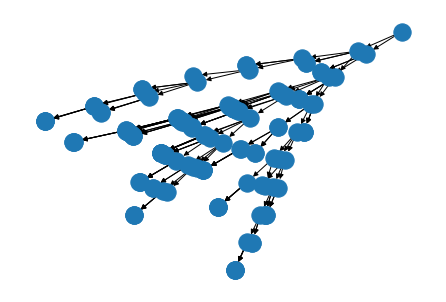

In [83]:
nx.draw_kamada_kawai(example1_tree)

In [259]:
def find_family(depth, node, graph):
    print (node)
    # find all predecessors and successors, up and down given depth    
    pred = []
    succ = []
    cur_level = [node]
    for _ in range(depth):
        next_level = list()
        for cur in cur_level:
            next_level += list(graph.predecessors(cur))
        cur_level = next_level
        pred += cur_level 
    cur_level = [node]
    for _ in range(depth):
        next_level = list()
        for cur in cur_level:
            next_level += list(graph.successors(cur))
        cur_level = next_level
        succ += cur_level 
    return pred+succ
# find_family(1,123,example1_tree)

In [267]:
robot_dropdown = alt.binding_select(options=list(example1.id.unique()))
robot_select = alt.selection_single(fields=['id'], bind=robot_dropdown, name="Robot", empty = 'none', init = {'id':0})

timeseries_robot = alt.Chart(example1_timeseries_melted).mark_point(
    filled = True, 
    size = 10, 
    opacity = 1
).encode(
    x = alt.X('time:Q'),
    y = alt.Y('number:Q')
).add_selection(
    robot_select
).transform_filter(
    robot_select
)

timeseries_robot

alt.Chart(...)

In [137]:
# example1_timeseries_melted

id                 name  time     number timestamp
0        0  Extraminer Boterson     1   0.000000       t_1
148      0  Extraminer Boterson     2  10.188414       t_2
296      0  Extraminer Boterson     3  19.509512       t_3
444      0  Extraminer Boterson     4  28.001504       t_4
592      0  Extraminer Boterson     5  35.701884       t_5
...    ...                  ...   ...        ...       ...
14207  147  Stoneminer Boterson    96  67.709511      t_96
14355  147  Stoneminer Boterson    97  67.102555      t_97
14503  147  Stoneminer Boterson    98  66.348602      t_98
14651  147  Stoneminer Boterson    99  65.435123      t_99
14799  147  Stoneminer Boterson   100  64.349223     t_100

[14800 rows x 5 columns]

KeyError: 0